** Grover's search **

## Abstract

This notebook implements Grover’s quantum search algorithm and analyzes its role as a foundational primitive for quantum speedups in unstructured search and combinatorial optimization. Beyond its pedagogical value, Grover’s algorithm underpins amplitude amplification techniques used in quantum optimization, quantum simulation, and hybrid quantum–classical workflows.

The notebook presents Grover’s algorithm both as a core quantum computing milestone and as a building block relevant to applied quantum systems, including optimization and machine learning pipelines.


## Why Grover’s Algorithm Matters

Grover’s algorithm is one of the two canonical quantum algorithms demonstrating provable quantum speedup, alongside Shor’s factoring algorithm. It provides a quadratic improvement for unstructured search problems, reducing complexity from (O(N)) to (O(\sqrt{N})).

More importantly for modern applications, Grover’s method generalizes to amplitude amplification, a key subroutine in quantum optimization and hybrid quantum–classical algorithms. As such, Grover’s algorithm is not merely a textbook example, but a foundational component of practical quantum computing architectures.


## Connection to Quantum Optimization and Hybrid Algorithms

Many quantum optimization algorithms, including quantum approximate optimization and quantum annealing hybrids, rely on amplitude amplification concepts rooted in Grover’s algorithm. These techniques enhance the probability of sampling low-energy solutions from complex search spaces.

In this sense, Grover’s algorithm forms a conceptual bridge between foundational quantum theory and applied quantum optimization pipelines, such as the QUBO formulations explored elsewhere in this repository. Understanding Grover’s algorithm is therefore essential for interpreting the mechanics of quantum speedups in real-world problem domains.


### Implications for Large-Scale Biological Search Problems

Many core problems in genomics, proteomics, and metabolomics can be expressed as large-scale search and pattern-matching tasks. Examples include identifying genomic variants with specific functional signatures, screening protein conformations for structural compatibility, or searching metabolomic state spaces for molecules with defined biochemical properties. These problems often involve exploring extremely large combinatorial landscapes.

Grover’s algorithm is relevant in this context because it provides a quadratic speedup for unstructured search problems. While this does not change exponential complexity classes, it can offer meaningful practical acceleration when the search space is extremely large and classical exhaustive search is prohibitive. In principle, a biologically informed oracle could be constructed to mark sequences, structures, or molecular states that satisfy predefined functional or structural criteria.

However, the practical impact depends critically on oracle construction. In biological systems, defining an oracle requires encoding complex biochemical knowledge into a quantum-evaluable function. This is a major challenge and currently remains an open research problem. Furthermore, many biological search tasks are highly structured, suggesting that hybrid quantum–classical approaches exploiting both problem structure and quantum amplitude amplification may be more realistic than pure unstructured search.

Consequently, Grover’s algorithm should be viewed not as a standalone solution, but as a potential acceleration primitive within future hybrid pipelines for large-scale biological discovery. Its relevance lies in demonstrating how quantum algorithms may contribute to navigating vast biological state spaces when combined with domain-specific modeling and classical preprocessing.


## Discussion

Grover’s algorithm demonstrates how quantum interference can reshape search landscapes by amplifying correct solutions while suppressing incorrect ones. Although the quadratic speedup is modest compared to exponential gains promised by some algorithms, its generality makes it one of the most practically relevant quantum primitives.

As quantum hardware matures, Grover-based subroutines are expected to play a growing role in hybrid quantum–classical workflows, particularly in large combinatorial search and optimization tasks where classical heuristics dominate today.


## Future Directions

Future work may explore generalized amplitude amplification techniques and their integration into hybrid optimization pipelines. Variants of Grover’s algorithm for noisy intermediate-scale quantum (NISQ) hardware and problem-structured oracles represent promising research directions for scalable quantum search applications.

Part A. Implementation 

In [ ]:
from math import sqrt, floor, pi
!pip install qiskit qiskit-aer matplotlib

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached pylatexenc-2.10-py3-none-any.whl

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
def _mc_phase_flip_on_bitstring(qc: QuantumCircuit, qubits, bitstr: str):   # qubit 0 is LSB
    
    n = len(qubits)                                                         # Map '0' controls into '1'
    for i, b in enumerate(reversed(bitstr)):
        if b == '0':
            qc.x(qubits[i])

                                                                        # Implement multi-controlled Z via H - mCX - H on the last qubit
    if n == 1:
        qc.z(qubits[0])
    else:
        qc.h(qubits[-1])
        qc.mcx(qubits[:-1], qubits[-1])
        qc.h(qubits[-1])

                                                                    # Uncompute the X masks
    for i, b in enumerate(reversed(bitstr)):
        if b == '0':
            qc.x(qubits[i])

def oracle_for_targets(n_qubits: int, targets): #Returns a Gate that flips the phase of each computational-basis state in `targets`.
                                                #`targets` is an iterable of n-bit strings 

    qc = QuantumCircuit(n_qubits, name='Oracle')
    q = list(range(n_qubits))
    for t in targets:
        assert len(t) == n_qubits,              #Each target must be an n-bit string
        _mc_phase_flip_on_bitstring(qc, q, t)
    return qc.to_gate()


In [ ]:
def diffusion(n_qubits: int):                             #Standard Grover diffusion operator
    qc = QuantumCircuit(n_qubits, name='Diffusion')
    q = list(range(n_qubits))

    qc.h(q)
    qc.x(q)
    qc.h(q[-1])
    if n_qubits == 1:
        qc.z(q[-1])
    else:
        qc.mcx(q[:-1], q[-1])
    qc.h(q[-1])
    qc.x(q)
    qc.h(q)

    return qc.to_gate()


In [ ]:
def grover_multi_target(n_qubits: int, targets, shots: int = 4096, backend=None):
    """
    Build & run Grover for multiple targets on n_qubits.
    - Initialize |+>^n
    - Applies k_opt = floor((pi/4)*sqrt(N/M)) iterations
    - Measure and return (qc, counts, k_opt)
    """
    from math import sqrt, floor, pi

    M = len(targets)
    assert M >= 1,                    #apply at least one target"
    N = 2**n_qubits
    k_opt = max(1, floor((pi/4) * sqrt(N / M)))

    qc = QuantumCircuit(n_qubits, n_qubits, name='Grover-MultiTarget')
    q = list(range(n_qubits))

    # Initialize |+>^n
    qc.h(q)

    # Build Oracle and Diffusion
    O = oracle_for_targets(n_qubits, targets)   # returns a Gate/Instruction
    D = diffusion(n_qubits)

    # Grover iterations
    for _ in range(k_opt):
        qc.append(O, q)
        qc.append(D, q)

    # Measure
    qc.measure(q, q)

    # ---transpile before running---
    sim = backend or AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    return qc, counts, k_opt


Optimal iterations (k_opt) = 3

--- Quantum Circuit (text view) ---
     ┌───┐┌─────────┐┌────────────┐┌─────────┐┌────────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0           ├┤0        ├┤0           ├┤0        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_1: ┤ H ├┤1        ├┤1           ├┤1        ├┤1           ├┤1        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_2: ┤ H ├┤2 Oracle ├┤2 Diffusion ├┤2 Oracle ├┤2 Diffusion ├┤2 Oracle ├»
     ├───┤│         ││            ││         ││            ││         │»
q_3: ┤ H ├┤3        ├┤3           ├┤3        ├┤3           ├┤3        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_4: ┤ H ├┤4        ├┤4           ├┤4        ├┤4           ├┤4        ├»
     └───┘└─────────┘└────────────┘└─────────┘└────────────┘└─────────┘»
c: 5/══════════════════════════════════════════════════════════════════»
                                                        

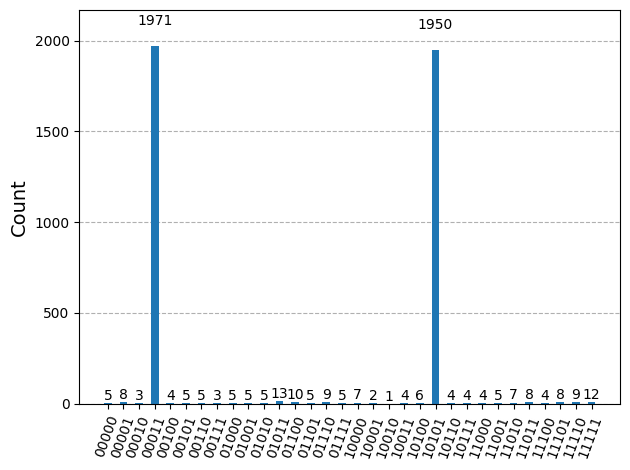

In [ ]:
#Part A. Demo: Multi-Target Grover
n = 5
targets = ["00011", "10101"]

# Run Grover’s search
qc_demo, counts_demo, k_demo = grover_multi_target(n, targets, shots=4096)

# Display results
print("Optimal iterations (k_opt) =", k_demo)
print("\n--- Quantum Circuit (text view) ---")
print(qc_demo.draw("text"))

# Plot the measurement distribution
plot_histogram(counts_demo)


Part B. Implementation

In [ ]:
from itertools import product
from math import sqrt, floor, pi

def cols_to_bitstring(cols, bits_per_row): #Convert row->col list
    def enc(c):
        return format(c, f'0{bits_per_row}b')
    return ''.join(enc(c) for c in cols)

def is_valid_board(cols):             #Check N-Queens constraints. Valid iff no same column and no diagonal conflicts.
    
    N = len(cols)
    for i in range(N):
        for j in range(i+1, N):
            if cols[i] == cols[j]:
                return False
            if abs(cols[i] - cols[j]) == abs(i - j):
                return False
    return True

def generate_valid_targets(N):   # Generate all valid N-Queens solutions and their bitstrings. 
                                        #Use bits_per_row = ceil(log2 N), and filters out out-of-range column for N not a power of 2.
    # Compute bits per row
    bits_per_row = (N-1).bit_length()
    targets_cols = []
    for cols in product(range(N), repeat=N):
        if is_valid_board(cols):
            targets_cols.append(list(cols))
    # Build bitstrings
    targets_bits = [cols_to_bitstring(cols, bits_per_row) for cols in targets_cols]
    return targets_cols, targets_bits, bits_per_row


N=4: #valid solutions (M) = 2
Valid boards (row->col): [[1, 3, 0, 2], [2, 0, 3, 1]]
k_opt = 8

--- 4-Queens Grover Circuit (text) ---
     ┌───┐┌─────────┐┌────────────┐┌─────────┐┌────────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0           ├┤0        ├┤0           ├┤0        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_1: ┤ H ├┤1        ├┤1           ├┤1        ├┤1           ├┤1        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_2: ┤ H ├┤2        ├┤2           ├┤2        ├┤2           ├┤2        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_3: ┤ H ├┤3        ├┤3           ├┤3        ├┤3           ├┤3        ├»
     ├───┤│  Oracle ││  Diffusion ││  Oracle ││  Diffusion ││  Oracle │»
q_4: ┤ H ├┤4        ├┤4           ├┤4        ├┤4           ├┤4        ├»
     ├───┤│         ││            ││         ││            ││         │»
q_5: ┤ H ├┤5        ├┤5           ├┤5        ├┤5           ├┤5 

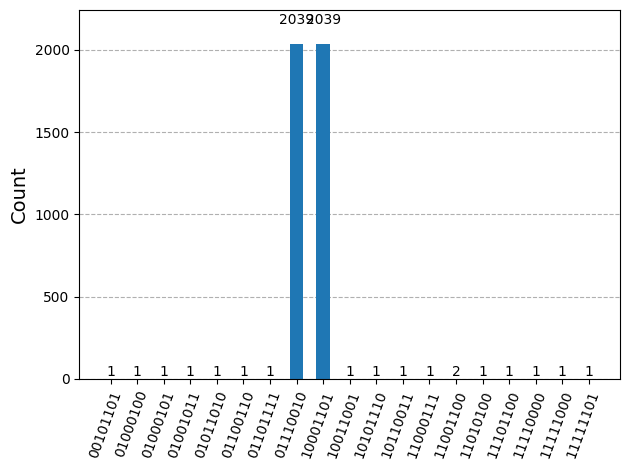

In [ ]:
# Generate valid boards and run Grover for N=4
N = 4
valid_cols_4, targets_4, bpr_4 = generate_valid_targets(N)
print(f"N={N}: #valid solutions (M) =", len(valid_cols_4))
print("Valid boards (row->col):", valid_cols_4)

n_qubits_4 = N * bpr_4
qc4, counts4, k4 = grover_multi_target(n_qubits_4, targets_4, shots=4096)
print("k_opt =", k4)

# Show circuit (text) + histogram
print("\n4-Queens Grover Circuit")
print(qc4.draw("text"))
plot_histogram(counts4)


N=5: #valid solutions (M) = 10
k_opt = 44

--- 5-Queens Grover Circuit (text) ---
      ┌───┐┌──────────┐┌─────────────┐┌──────────┐┌─────────────┐┌──────────┐»
 q_0: ┤ H ├┤0         ├┤0            ├┤0         ├┤0            ├┤0         ├»
      ├───┤│          ││             ││          ││             ││          │»
 q_1: ┤ H ├┤1         ├┤1            ├┤1         ├┤1            ├┤1         ├»
      ├───┤│          ││             ││          ││             ││          │»
 q_2: ┤ H ├┤2         ├┤2            ├┤2         ├┤2            ├┤2         ├»
      ├───┤│          ││             ││          ││             ││          │»
 q_3: ┤ H ├┤3         ├┤3            ├┤3         ├┤3            ├┤3         ├»
      ├───┤│          ││             ││          ││             ││          │»
 q_4: ┤ H ├┤4         ├┤4            ├┤4         ├┤4            ├┤4         ├»
      ├───┤│          ││             ││          ││             ││          │»
 q_5: ┤ H ├┤5         ├┤5            ├┤5         

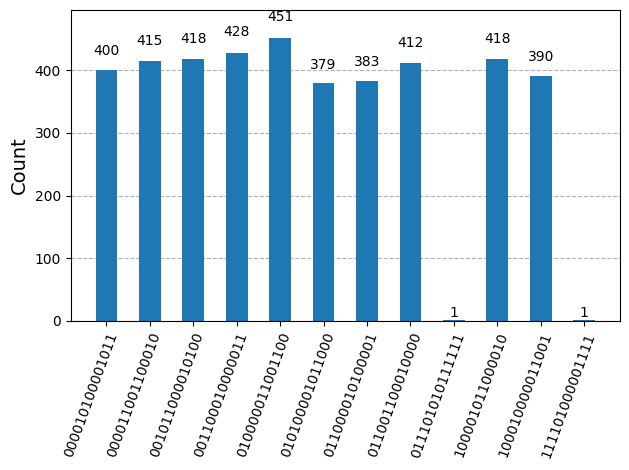

In [ ]:
# Generate valid boards and run Grover for N=5
N = 5
valid_cols_5, targets_5, bpr_5 = generate_valid_targets(N)
print(f"N={N}: #valid solutions (M) =", len(valid_cols_5))


n_qubits_5 = N * bpr_5  # bits_per_row = 3 for N=5
qc5, counts5, k5 = grover_multi_target(n_qubits_5, targets_5, shots=4096)
print("k_opt =", k5)

print("\n5-Queens Grover Circuit")
print(qc5.draw("text"))
plot_histogram(counts5)
